In [1]:
!kaggle datasets download -d saddamazyazy/go-to-college-dataset

In [2]:
!unzip go-to-college-dataset.zip

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import classification_report

In [4]:
df = pd.read_csv('data.csv')

In [5]:
df

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,will_go_to_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False
...,...,...,...,...,...,...,...,...,...,...,...
995,Vocational,A,Female,Very Interested,Rural,49,7420000,63.6,85.99,True,True
996,Academic,B,Female,Less Interested,Rural,51,7480000,84.3,89.72,True,True
997,Vocational,A,Male,Less Interested,Urban,49,5550000,75.2,79.56,False,True
998,Academic,B,Male,Uncertain,Rural,53,5840000,105.8,87.18,True,True


In [6]:
df.isna().sum()

type_school              0
school_accreditation     0
gender                   0
interest                 0
residence                0
parent_age               0
parent_salary            0
house_area               0
average_grades           0
parent_was_in_college    0
will_go_to_college       0
dtype: int64

In [7]:
df_str = df.select_dtypes(include='object')
df_str

,type_school,school_accreditation,gender,interest,residence
0,Academic,A,Male,Less Interested,Urban
1,Academic,A,Male,Less Interested,Urban
2,Academic,B,Female,Very Interested,Urban
3,Vocational,B,Male,Very Interested,Rural
4,Academic,A,Female,Very Interested,Urban
...,...,...,...,...,...
995,Vocational,A,Female,Very Interested,Rural
996,Academic,B,Female,Less Interested,Rural
997,Vocational,A,Male,Less Interested,Urban
998,Academic,B,Male,Uncertain,Rural


In [8]:
for col in df_str.columns:
    print(col, df_str[col].unique())

type_school ['Academic' 'Vocational']
school_accreditation ['A' 'B']
gender ['Male' 'Female']
interest ['Less Interested' 'Very Interested' 'Uncertain' 'Not Interested'
 'Interested']
residence ['Urban' 'Rural']


In [9]:
def preprocess(df):
    df_str = df.select_dtypes(include='object')
    enc = OrdinalEncoder(categories=[
        df_str[col].unique() if col != 'interest' else [
            'Not Interested', 'Less Interested', 'Uncertain', 'Interested', 'Very Interested']
        for col in df_str.columns
    ])
    df = pd.concat([
        pd.DataFrame(enc.fit_transform(df_str), columns=df_str.columns, index=df_str.index),
        df.select_dtypes(exclude='object')
    ], axis=1)
    
    return df.drop(columns=['will_go_to_college']), df['will_go_to_college']

# One model to rule them all!

In [10]:
np.random.seed(13)

train, test = train_test_split(df, test_size=0.3)

train_x, train_y = preprocess(train)
test_x, test_y = preprocess(test)

In [11]:
model = DecisionTreeClassifier()

model.fit(train_x, train_y)
print(classification_report(model.predict(test_x), test_y))

              precision    recall  f1-score   support

       False       0.71      0.76      0.73       140
        True       0.77      0.72      0.75       160

    accuracy                           0.74       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.74      0.74      0.74       300



In [12]:
sorted(list(zip(train.columns, model.feature_importances_)),
       key=lambda x: x[1],
       reverse=True)

[('average_grades', 0.4230893191101725),
 ('parent_salary', 0.20172634884632726),
 ('house_area', 0.17037989602130768),
 ('residence', 0.05032889563955828),
 ('interest', 0.039254216832914204),
 ('school_accreditation', 0.028831115054717533),
 ('parent_was_in_college', 0.02808403361344538),
 ('parent_age', 0.027668593672161897),
 ('type_school', 0.02682805739987149),
 ('gender', 0.0038095238095238095)]

<ipython-input-13-d66fdd29176d>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


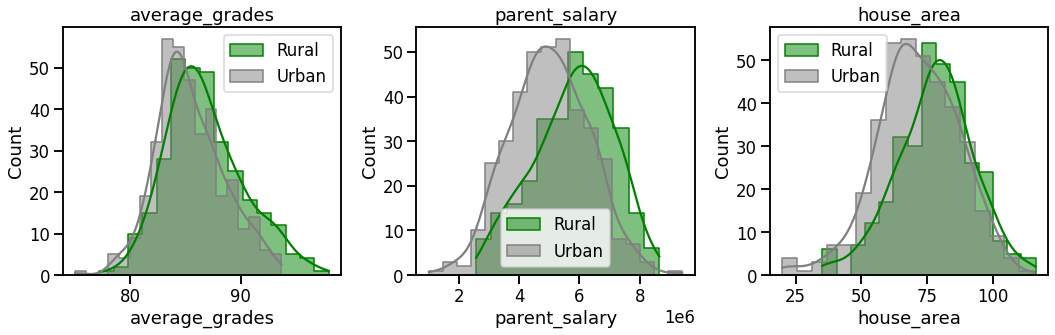

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

for cur_ax, feature in zip(axes, ['average_grades', 'parent_salary', 'house_area']):
    sns.histplot(train[train['residence'] == 'Rural'][feature],
                 color='green',
                 label='Rural',
                 element='step',
                 kde=True,
                 ax=cur_ax)
    sns.histplot(train[train['residence'] == 'Urban'][feature],
                 color='gray',
                 label='Urban',
                 element='step',
                 kde=True,
                 ax=cur_ax)
    
    cur_ax.set_title(feature)
    cur_ax.legend()
    
fig.tight_layout()
fig.show()

<ipython-input-14-c68ac4954a4d>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


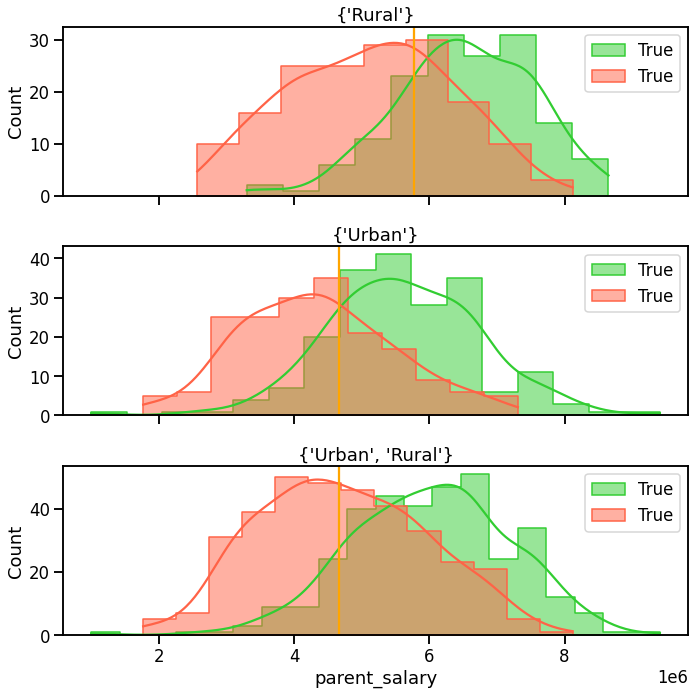

In [14]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 10), sharex=True)

for cur_ax, residence_values in zip(axes, [{'Rural'}, {'Urban'}, {'Rural', 'Urban'}]):
    subset = train[train['residence'].isin(residence_values)]
    sns.histplot(subset[subset['will_go_to_college']]['parent_salary'],
                 color='limegreen',
                 label='True',
                 element='step',
                 kde=True,
                 ax=cur_ax)
    sns.histplot(subset[~subset['will_go_to_college']]['parent_salary'],
                 color='tomato',
                 label='True',
                 element='step',
                 kde=True,
                 ax=cur_ax)
    
    threshold = (
        DecisionTreeClassifier(max_depth=1)
        .fit(subset[['parent_salary']], subset['will_go_to_college'])
        .tree_.threshold[0]
    )
    cur_ax.axvline(threshold, color='orange')
    cur_ax.set_title(residence_values)
    cur_ax.legend()
    
fig.tight_layout()
fig.show()

In [15]:
print(export_text(model, feature_names=list(train_x.columns)))

|--- average_grades <= 86.81
|   |--- parent_salary <= 4665000.00
|   |   |--- average_grades <= 78.88
|   |   |   |--- house_area <= 53.90
|   |   |   |   |--- class: False
|   |   |   |--- house_area >  53.90
|   |   |   |   |--- class: True
|   |   |--- average_grades >  78.88
|   |   |   |--- house_area <= 77.60
|   |   |   |   |--- house_area <= 44.40
|   |   |   |   |   |--- parent_age <= 54.00
|   |   |   |   |   |   |--- class: False
|   |   |   |   |   |--- parent_age >  54.00
|   |   |   |   |   |   |--- class: True
|   |   |   |   |--- house_area >  44.40
|   |   |   |   |   |--- average_grades <= 81.82
|   |   |   |   |   |   |--- average_grades <= 81.75
|   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |--- average_grades >  81.75
|   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |--- average_grades >  81.82
|   |   |   |   |   |   |--- class: False
|   |   |   |--- house_area >  77.60
|   |   |   |   |--- parent_was_in_college <= 0.50
| 

# Two models to rule them all!

In [16]:
for residence_value in ['Rural', 'Urban']:
    train_x, train_y = preprocess(train[train['residence'] == residence_value])
    test_x, test_y = preprocess(test[test['residence'] == residence_value])
    
    model = DecisionTreeClassifier().fit(train_x, train_y)
    print(residence_value)
    print(classification_report(model.predict(test_x), test_y))

Rural
              precision    recall  f1-score   support

       False       0.77      0.89      0.83        57
        True       0.92      0.82      0.87        85

    accuracy                           0.85       142
   macro avg       0.85      0.86      0.85       142
weighted avg       0.86      0.85      0.85       142

Urban
              precision    recall  f1-score   support

       False       0.81      0.88      0.84        77
        True       0.88      0.80      0.84        81

    accuracy                           0.84       158
   macro avg       0.84      0.84      0.84       158
weighted avg       0.84      0.84      0.84       158

